In [2]:
#imports libs and data
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pickle, json

from scipy.ndimage.filters import gaussian_filter1d as smooth

import Classes.LPPic_fields as fl
import Classes.LPPic as LP
import Classes.LPPic_newwalls as nw
from functions import (simpleplot, ne_Bolz, Te_eff_calcl, phi_drop,
                        sigma_maxw_unsat,
                        sigma_maxw_sat,
                        newSigma_maxw, maxwE
                      ,)

import matplotlib as mpl
import matplotlib.pyplot as plt

qe = 1.6021766E-19
me =  9.109E-31 
mi = 219.6E-27
eps0 = 8.854187817e-12

run = pickle.load( open( "save_run.p", "rb" ) )
data_all = pickle.load( open( "save_data_all.p", "rb" ) )
PIC = pickle.load( open( "PICvalues.dat", "rb" ) )
savepath = "../images/"

sigma_0 = 0.5
sigma_max= 2.9

In [3]:
Paper_style = json.load(open("Paperstyle.json",'r'))
mpl.style.use(Paper_style)

In [4]:
#plot functions
def subs(Nsub = 1):
    
    fig, axarr = plt.subplots(1,Nsub,figsize = (Nsub*3.5,3.5))

    if Nsub == 1:
        axarr = [axarr]
        
    return fig, axarr

def axLabels(ax,title,xlabel,ylabel):
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

In [5]:
data = pickle.load(open("bulk_EVDF.dat","rb"))
data_sh = pickle.load(open("sheath_EVDF.dat","rb"))


45.413850510015294


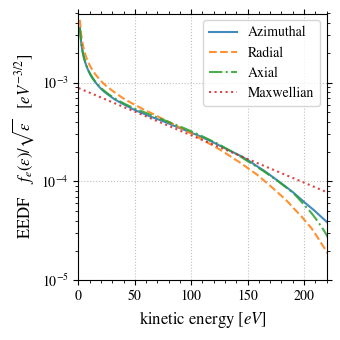

In [6]:
#Plot EEDF
#for the following epsilon* :
#['200', '25', '10', '50']
epsToPlot = '50'


def plt_EEDF(data):
    vtab, vx, vy, vz = [data[s][epsToPlot] for s in ["vtab",'vx','vy','vz']]
    vtab = (vtab[1:] + vtab[:-1])/2
    if True:
        vxNormed, vyNormed, vzNormed = vx/vx.sum(), vy/vy.sum(), vz/vz.sum()
    else:
        vxNormed, vyNormed, vzNormed = vx, vy, vz

    etab = vtab**2*np.sign(vtab)*me/(2*qe)
    Te = ((etab*vxNormed/vxNormed.max()).std() + (etab*vzNormed/vzNormed.max()).std() + (etab*vyNormed/vyNormed.max()).std())

    def return_absE(f,vtab):
        import math
        mask1 = vtab > 0
        Nbin1 = sum(mask1)
        Nbin2 = len(vtab) - Nbin1
        Nbin = max(Nbin1, Nbin2)
        e = np.zeros(Nbin)

        e[:Nbin1] += abs(f[mask1])
        e[:Nbin2] += abs(f[np.logical_not(mask1)][::-1])
        return (e/2)

    vxNormed, vyNormed, vzNormed = return_absE(vxNormed,vtab), return_absE(vyNormed,vtab), return_absE(vzNormed,vtab)
    etab = np.linspace(0,300,len(vxNormed))

    e = np.linspace(0.1,220,200)
    print(Te)
    toplot = np.sqrt(np.abs(e))**-1*maxwE(np.abs(e),Te)
    #toplot *= 5e-14
    toplot /= maxwE(np.abs(e),Te).sum()
    toplot *= 0.5

    alpha = 0.85
    with mpl.style.context({"lines.linewidth":1.5}):

        
        ax.plot(etab,np.sqrt(np.abs(etab))**-1*smooth(vxNormed,2), label = r"Azimuthal",
               alpha = alpha, linestyle = "-")
        ax.plot(etab,np.sqrt(np.abs(etab))**-1*smooth(vyNormed,2), label = r"Radial",
               alpha = alpha, linestyle = "--")
        ax.plot(etab,np.sqrt(np.abs(etab))**-1*smooth(vzNormed,2), label = r"Axial",
               alpha = alpha, linestyle = "-.")

        ax.plot(e,toplot,":", label = "Maxwellian",
               alpha = alpha)

fig, axarr  = subs(1)
ax = axarr[0]
plt_EEDF(data)
#plt_EEDF(data_sh)
ax.set_xlim(0,220)
ax.set_yscale("log")
ax.set_ylim(1e-5,5e-3)
axLabels(ax,"","kinetic energy $[eV]$", "EEDF $\quad f_e(\epsilon) / \sqrt{\epsilon}  \quad [eV^{-3/2}]$")
plt.savefig(savepath+"EEDF")

44.85156600917578
25.660044239547013


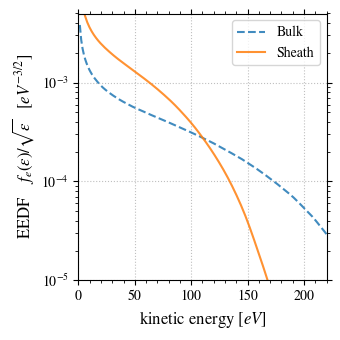

In [7]:

def plt_EEDF_tot(data, lab = ""):
    vtab, vx, vy, vz = [data[s][epsToPlot] for s in ["vtab",'vx','vy','vz']]
    vtab = (vtab[1:] + vtab[:-1])/2
    
    v = vx + vy + vz
    if True:
        vNormed = v/v.sum()
    else:
        vNormed = v

    etab = vtab**2*np.sign(vtab)*me/(2*qe)
    Te = 3*((etab*vNormed/vNormed.max()).std() )

    def return_absE(f,vtab):
        import math
        mask1 = vtab > 0
        Nbin1 = sum(mask1)
        Nbin2 = len(vtab) - Nbin1
        Nbin = max(Nbin1, Nbin2)
        e = np.zeros(Nbin)

        e[:Nbin1] += abs(f[mask1])
        e[:Nbin2] += abs(f[np.logical_not(mask1)][::-1])
        return (e/2)

    vNormed = return_absE(vNormed,vtab)
    etab = np.linspace(0,300,len(vNormed))

    e = np.linspace(0.1,220,200)
    print(Te)
    toplot = np.sqrt(np.abs(e))**-1*maxwE(np.abs(e),Te)
    #toplot *= 5e-14
    toplot /= maxwE(np.abs(e),Te).sum()
    toplot *= 0.5

    alpha = 0.85
    with mpl.style.context({"lines.linewidth":1.5}):
        styl = "-"
        if lab == "Bulk":  styl = "--"

        
        ax.plot(etab,np.sqrt(np.abs(etab))**-1*smooth(vNormed,2), label = lab,
               alpha = alpha, linestyle = styl )

fig, axarr  = subs(1)
ax = axarr[0]
plt_EEDF_tot(data, "Bulk")
plt_EEDF_tot(data_sh, "Sheath")
ax.set_xlim(0,220)
ax.set_yscale("log")
ax.set_ylim(1e-5,5e-3)
axLabels(ax,"","kinetic energy $[eV]$", "EEDF $\quad f_e(\epsilon) / \sqrt{\epsilon}  \quad [eV^{-3/2}]$")
plt.savefig(savepath+"EEDF_compSheathBulk")

45.413850510015294
44.85156600917578
25.660044239547013


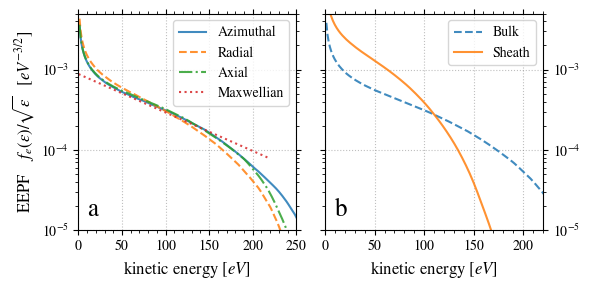

In [8]:
#fig, axarr  = subs(2)
#for the following epsilon* :
#['200', '25', '10', '50']
epsToPlot = '50'

fig, axarr  = plt.subplots(1,2,figsize=(6,3))
ax = axarr[0]
plt_EEDF(data)
ax.set_xlim(0,250)
ax.set_yscale("log")
ax.set_ylim(1e-5,5e-3)
axLabels(ax,"","kinetic energy $[eV]$", "EEPF $\quad f_e(\epsilon) / \sqrt{\epsilon}  \quad [eV^{-3/2}]$")

ax = axarr[1]
plt_EEDF_tot(data, "Bulk")
plt_EEDF_tot(data_sh, "Sheath")
ax.set_xlim(0,220)
ax.set_yscale("log")
ax.set_ylim(1e-5,5e-3)
axLabels(ax,"","kinetic energy $[eV]$", "EEPF $\quad f_e(\epsilon) / \sqrt{\epsilon}  \quad [eV^{-3/2}]$")
axLabels(ax,"","kinetic energy $[eV]$", "")

ax.tick_params( reset = True,
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    #left=False,      # ticks along the bottom edge are off
    labelright=True,
    labelleft=False) # labels along the bottom edge are off

axarr[0].text(10,1.5e-5,"a", fontsize = 18)
axarr[1].text(10,1.5e-5,"b", fontsize = 18)
plt.savefig(savepath+"EEDF_2")


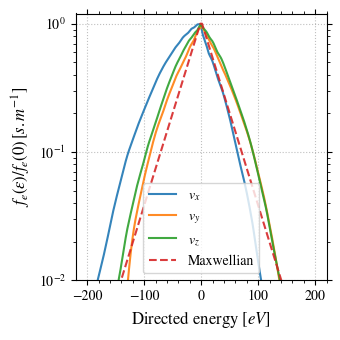

In [8]:
#Plot EVDF
vtab, vx, vy, vz = [data_sh[s]['200'] for s in ["vtab",'vx','vy','vz']]
vtab = (vtab[1:] + vtab[:-1])/2
vxNormed, vyNormed, vzNormed = vx/vx.max(), vy/vy.max(), vz/vz.max()
etab = vtab**2*np.sign(vtab)*me/(2*qe)

Te = ((etab*vxNormed).std() + (etab*vzNormed).std() + (etab*vzNormed).std())
e = np.linspace(-300,300,200)
toplot = np.sqrt(np.abs(e))**-1*maxwE(np.abs(e),Te)
toplot /= toplot.max()
   
alpha = 0.9
with mpl.style.context({"lines.linewidth":1.5}):
    
    fig, axarr  = subs(1)
    ax = axarr[0]
    ax.plot(etab,smooth(vxNormed,2), label = r"$v_{x } $",
           alpha = alpha)
    ax.plot(etab,smooth(vyNormed,2), label = r"$v_{y } $",
           alpha = alpha)
    ax.plot(etab,smooth(vzNormed,2), label = r"$v_{z }$",
           alpha = alpha)
    
    ax.plot(e,toplot,"--", label = "Maxwellian",
           alpha = alpha)


ax.set_xlim(-220,220)
ax.set_yscale("log")
ax.set_ylim(1e-2,1.2)
axLabels(ax,"","Directed energy $[eV]$", "$f_e(\epsilon)/f_e(0) \/ [s.m^{-1}]$")
plt.savefig(savepath+"EVDF")

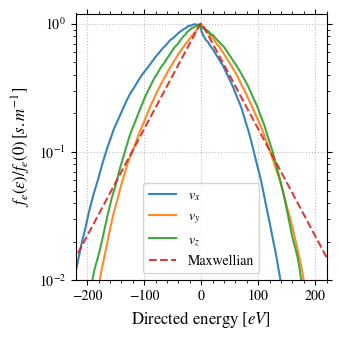

In [9]:
#Plot EVDF
vtab, vx, vy, vz = [data[s]['200'] for s in ["vtab",'vx','vy','vz']]
vtab = (vtab[1:] + vtab[:-1])/2
vxNormed, vyNormed, vzNormed = vx/vx.max(), vy/vy.max(), vz/vz.max()
etab = vtab**2*np.sign(vtab)*me/(2*qe)

Te = ((etab*vxNormed).std() + (etab*vzNormed).std() + (etab*vzNormed).std())
e = np.linspace(-300,300,200)
toplot = np.sqrt(np.abs(e))**-1*maxwE(np.abs(e),Te)
toplot /= toplot.max()
   
alpha = 0.9
with mpl.style.context({"lines.linewidth":1.5}):
    
    fig, axarr  = subs(1)
    ax = axarr[0]
    ax.plot(etab,smooth(vxNormed,2), label = r"$v_{x } $",
           alpha = alpha)
    ax.plot(etab,smooth(vyNormed,2), label = r"$v_{y } $",
           alpha = alpha)
    ax.plot(etab,smooth(vzNormed,2), label = r"$v_{z }$",
           alpha = alpha)
    
    ax.plot(e,toplot,"--", label = "Maxwellian",
           alpha = alpha)


ax.set_xlim(-220,220)
ax.set_yscale("log")
ax.set_ylim(1e-2,1.2)
axLabels(ax,"","Directed energy $[eV]$", "$f_e(\epsilon)/f_e(0) \/ [s.m^{-1}]$")
plt.savefig(savepath+"EVDF")